Implementation of DeepDream as taught on https://www.tensorflow.org/tutorials/generative/deepdream

In [1]:
import tensorflow as tf

import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image
tf.debugging.set_log_device_placement(True)

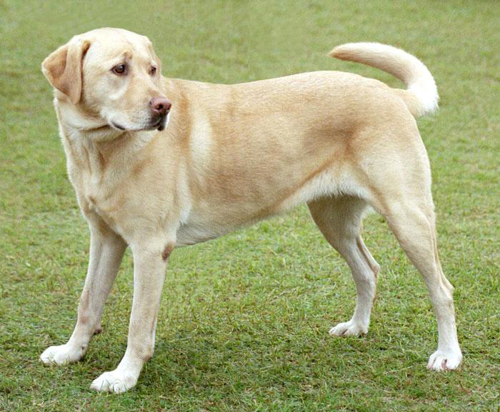

In [2]:

url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
show(original_img)

In [3]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/tas

In [38]:
# Maximize the activations of these layers
names = ['mixed0']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [39]:
def calc_loss(img, model):
    img_batch=tf.expand_dims(img, axis=0)
    layer_activation=model(img_batch)
    if len(layer_activation) == 1:
        layer_activation = [layer_activation]
    
    losses= []
    for act in layer_activation:
        loss= tf.math.reduce_mean(act)
        losses.append(loss)
    
    return tf.math.reduce_sum(losses)

In [40]:
class DeepDream(tf.Module):
    def __init__(self, model):
        self.model=model
    
    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None, None, 3], dtype=tf.float32),
            tf.TensorSpec(shape=[], dtype=tf.int32),
            tf.TensorSpec(shape=[], dtype=tf.float32),)
    )
    def __call__(self, img, steps, step_size):
        loss=tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                tape.watch(img)
                loss = calc_loss(img, self.model)
                
                gradients = tape.gradient(loss, img)
                
                gradients /= tf.math.reduce_std(gradients) + 1e-8
                
                img = img + gradients*step_size
                img = tf.clip_by_value(img, -1, 1)
        return loss, img

In [41]:
deepdream=DeepDream(dream_model)

In [42]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
    img=tf.keras.applications.inception_v3.preprocess_input(img)
    img=tf.convert_to_tensor(img)
    step_size = tf.convert_to_tensor(step_size)
    
    steps_remaining=steps
    
    step = 0
    
    while steps_remaining:
        if steps_remaining>100:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(steps_remaining)
        
        steps_remaining -= run_steps
        steps+= run_steps
        
        loss, img = deepdream(img, run_steps, tf.constant(step_size))
        
        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Step {}, loss {}".format(step, loss))
        
    result= deprocess(img)
    display.clear_output(wait=True)
    
    show(result)
    
    return result

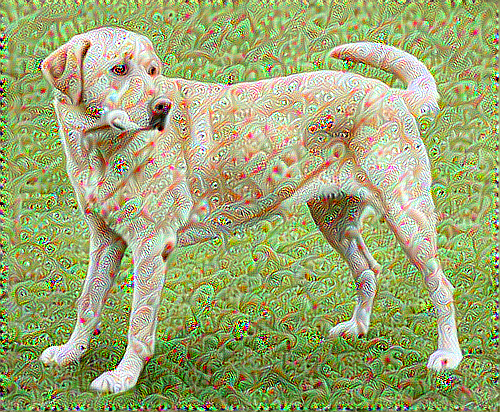

In [43]:
#simply implementing the above 
dream_img = run_deep_dream_simple(img=original_img,steps=150, step_size=0.01)

There are a few issues with this first attempt:

The output is noisy (this could be addressed with a tf.image.total_variation loss).
The image is low resolution.
The patterns appear like they're all happening at the same granularity.
One approach that addresses all these problems is applying gradient ascent at different scales. This will allow patterns generated at smaller scales to be incorporated into patterns at higher scales and filled in with additional detail.

To do this you can perform the previous gradient ascent approach, then increase the size of the image (which is referred to as an octave), and repeat this process for multiple octaves.

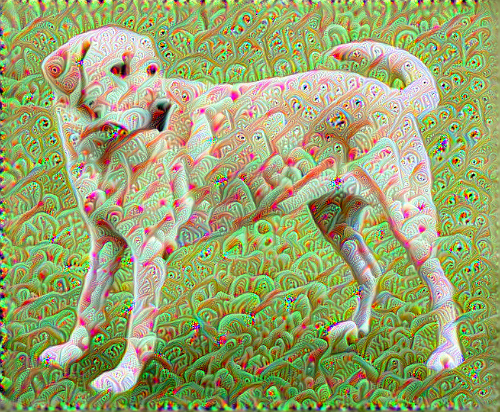

8.306907653808594

In [44]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
    new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

    img = tf.image.resize(img, new_shape).numpy()

    img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end-start

Scaling up with tiles

Start by implementing the random shift

Then a tiled equivalent of the deepdream function defined earlier

Putting this together gives a scalable, octave-aware deepdream implementation:


In [45]:
def random_roll(img, maxroll):
    shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
    shift_down, shift_right = shift[0],shift[1] 
    img_rolled = tf.roll(tf.roll(img, shift_right, axis=1), shift_down, axis=0)
    return shift_down, shift_right, img_rolled

class TiledGradients(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
            tf.TensorSpec(shape=[], dtype=tf.int32),))
    
    def __call__(self, img, tile_size=512):
        shift_down, shift_right, img_rolled = random_roll(img, tile_size)
        gradients = tf.zeros_like(img_rolled)
        xs = tf.range(0, img_rolled.shape[0], tile_size)[:-1]
        if not tf.cast(len(xs), bool):
            xs = tf.constant([0])
        ys = tf.range(0, img_rolled.shape[1], tile_size)[:-1]
        if not tf.cast(len(ys), bool):
            ys = tf.constant([0])

        for x in xs:
            for y in ys:
                with tf.GradientTape() as tape:
                    tape.watch(img_rolled)
                    img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
                    loss = calc_loss(img_tile, self.model)
                
                gradients = gradients + tape.gradient(loss, img_rolled)

        gradients = tf.roll(tf.roll(gradients, -shift_right, axis=1), -shift_down, axis=0)

        gradients /= tf.math.reduce_std(gradients) + 1e-8 

        return gradients 

In [46]:
get_tiled_gradients = TiledGradients(dream_model)

In [49]:
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01, 
                                octaves=range(-2,3), octave_scale=1.3):
    base_shape = tf.shape(img)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    
    initial_shape = img.shape[:-1]
    img = tf.image.resize(img, initial_shape)
    for octave in octaves:
        new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
        img = tf.image.resize(img, tf.cast(new_size, tf.int32))

    for step in range(steps_per_octave):
        gradients = get_tiled_gradients(img)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

        if step % 10 == 0:
            display.clear_output(wait=True)
            show(deprocess(img))
            print ("Octave {}, Step {}".format(octave, step))
    
    result = deprocess(img)
    return result

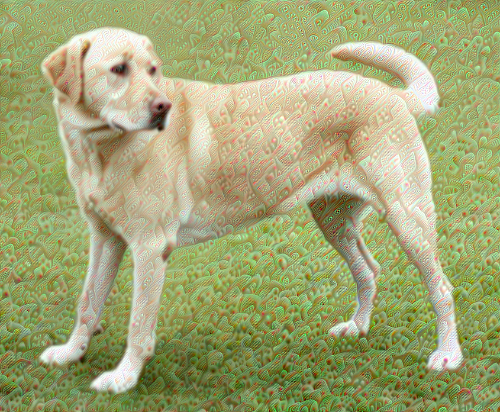

In [50]:
img = run_deep_dream_with_octaves(img=original_img, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)